Connected to Python 3.12.3

In [ ]:
# Import necessary libraries
import pandas as pd
from zipfile import ZipFile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

2024-12-03 03:00:09.955886: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 03:00:09.975808: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 03:00:09.982041: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 03:00:09.997306: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 03:00:10.840989: W tensorflow/compiler/tf2

In [ ]:
# Load the dataset
with ZipFile('/home/ubuntu/NLP_Data/train.csv.zip', 'r') as zip_file:
    with zip_file.open('train.csv') as file:
        df = pd.read_csv(file)

# Display dataset information
print(df.info())
print(df.head())

# Drop rows with null values
df = df.dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB
None
   id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_

In [ ]:
# Text preprocessing
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['question1'] = df['question1'].apply(clean_text)
df['question2'] = df['question2'].apply(clean_text)

print("Cleaned Text:\n", df[['question1', 'question2']].head())

Cleaned Text:
                                            question1  \
0  what is the step by step guide to invest in sh...   
1     what is the story of kohinoor kohinoor diamond   
2  how can i increase the speed of my internet co...   
3   why am i mentally very lonely how can i solve it   
4  which one dissolve in water quikly sugar salt ...   

                                           question2  
0  what is the step by step guide to invest in sh...  
1  what would happen if the indian government sto...  
2  how can internet speed be increased by hacking...  
3  find the remainder when math2324math is divide...  
4             which fish would survive in salt water  


In [ ]:
# Feature Engineering
df['q1_len'] = df['question1'].apply(len)
df['q2_len'] = df['question2'].apply(len)
df['len_diff'] = abs(df['q1_len'] - df['q2_len'])

def word_overlap(q1, q2):
    q1_words = set(q1.split())
    q2_words = set(q2.split())
    return len(q1_words.intersection(q2_words))

def common_word_ratio(q1, q2):
    q1_words = set(q1.split())
    q2_words = set(q2.split())
    union_len = len(q1_words.union(q2_words))
    return len(q1_words.intersection(q2_words)) / union_len if union_len > 0 else 0

df['word_overlap'] = df.apply(lambda row: word_overlap(row['question1'], row['question2']), axis=1)
df['common_word_ratio'] = df.apply(lambda row: common_word_ratio(row['question1'], row['question2']), axis=1)

# Additional Features: Named Entity Overlap
import spacy
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "lemmatizer"])

def named_entity_overlap(q1, q2):
    q1_entities = {ent.text for ent in nlp(q1).ents}
    q2_entities = {ent.text for ent in nlp(q2).ents}
    return len(q1_entities.intersection(q2_entities))

df['named_entity_overlap'] = df.apply(lambda row: named_entity_overlap(row['question1'], row['question2']), axis=1)

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,len_diff,word_overlap,common_word_ratio,named_entity_overlap
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,65,56,9,11,0.916667,0
1,1,3,4,what is the story of kohinoor kohinoor diamond,what would happen if the indian government sto...,0,46,83,37,4,0.285714,0
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,72,58,14,4,0.200000,0
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math2324math is divide...,0,48,55,7,0,0.000000,0
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0,73,38,35,4,0.250000,0


In [ ]:
# Additional Features: N-gram Overlap
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from concurrent.futures import ThreadPoolExecutor
import numpy as np
from tqdm import tqdm

def ngram_overlap_batch(questions1, questions2, n=2):
    """
    Calculate n-gram overlap for a batch of questions.
    """
    # Combine all questions into a single list
    combined_questions = questions1 + questions2

    # Fit CountVectorizer on the combined batch
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words="english")
    try:
        vectorizer.fit(combined_questions)
    except ValueError:
        # Handle empty vocabulary
        return [0] * len(questions1)

    # Transform each question into n-grams
    q1_ngrams = [set(vectorizer.transform([q]).nonzero()[1]) for q in questions1]
    q2_ngrams = [set(vectorizer.transform([q]).nonzero()[1]) for q in questions2]

    # Compute overlaps
    overlaps = []
    for ngrams1, ngrams2 in zip(q1_ngrams, q2_ngrams):
        if not ngrams1 or not ngrams2:
            overlaps.append(0)
        else:
            overlaps.append(len(ngrams1.intersection(ngrams2)) / len(ngrams1.union(ngrams2)))
    return overlaps

def process_batches_in_parallel(df, batch_size=1000, n=2, num_threads=8):
    """
    Process DataFrame batches in parallel for n-gram overlap.
    """
    num_batches = len(df) // batch_size + (1 if len(df) % batch_size > 0 else 0)
    batches = [df.iloc[i * batch_size: (i + 1) * batch_size] for i in range(num_batches)]

    def process_batch(batch):
        return ngram_overlap_batch(batch['question1'].tolist(), batch['question2'].tolist(), n=n)

    results = []
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        for result in tqdm(executor.map(process_batch, batches), total=len(batches), desc=f"Processing {n}-grams"):
            results.extend(result)
    return results

In [ ]:
# Process bigrams
df['bigram_overlap'] = process_batches_in_parallel(df, batch_size=5000, n=2)
df['trigram_overlap'] = process_batches_in_parallel(df, batch_size=5000, n=3)

print(df[['bigram_overlap', 'trigram_overlap']].head())

Processing 3-grams: 100%|██████████| 81/81 [02:55<00:00,  2.16s/it]

   bigram_overlap  trigram_overlap
0        0.833333         0.800000
1        0.285714         0.166667
2        0.000000         0.000000
3        0.000000         0.000000
4        0.000000         0.000000


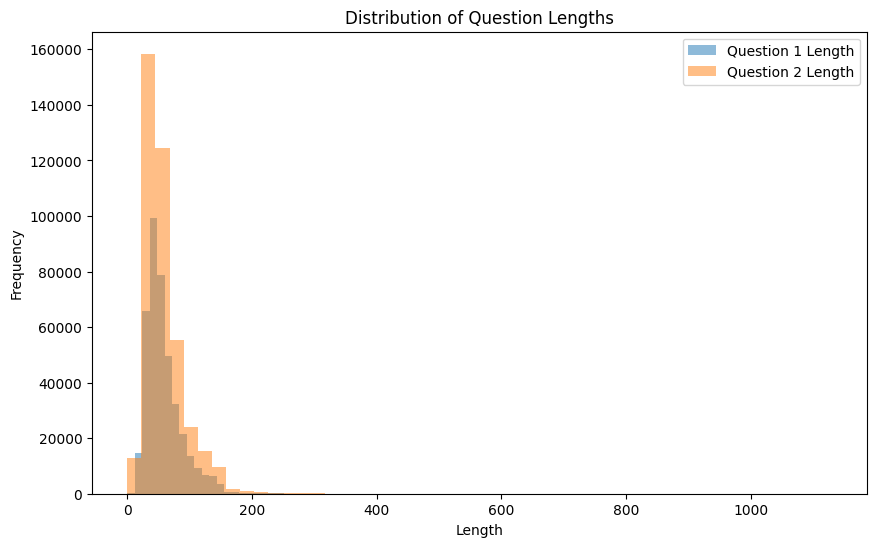

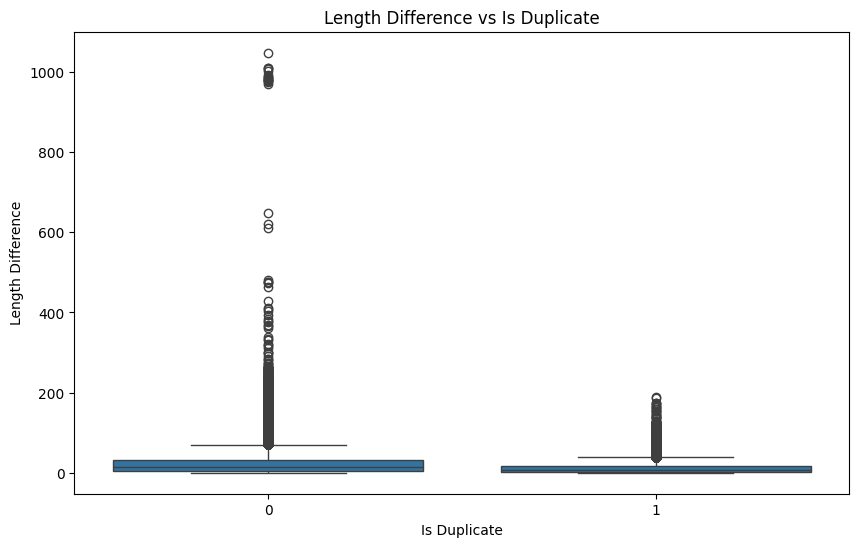

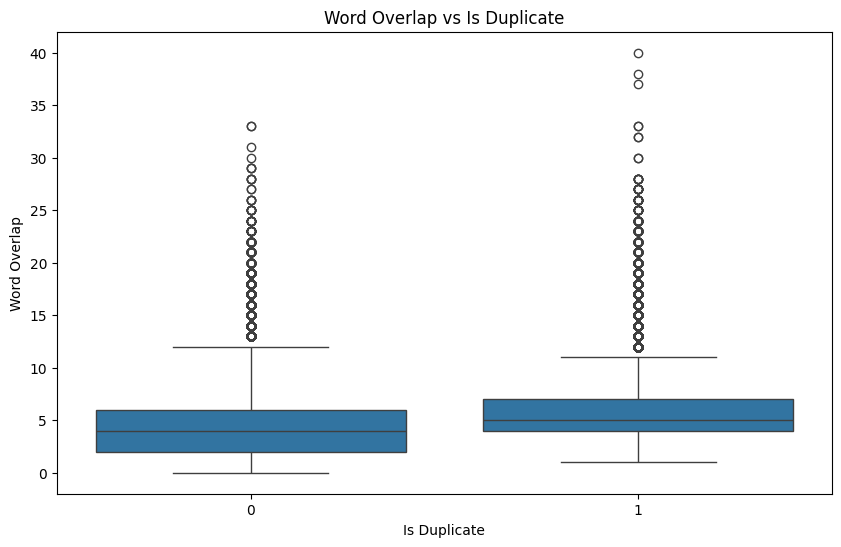

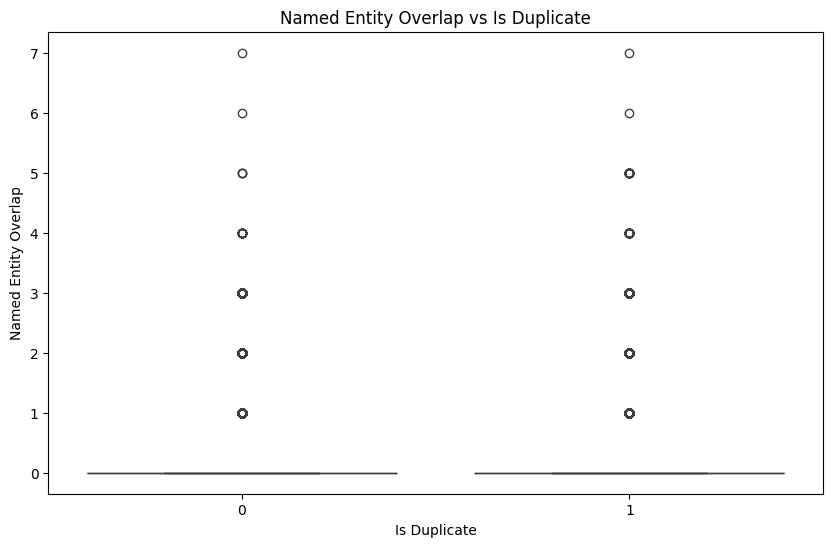

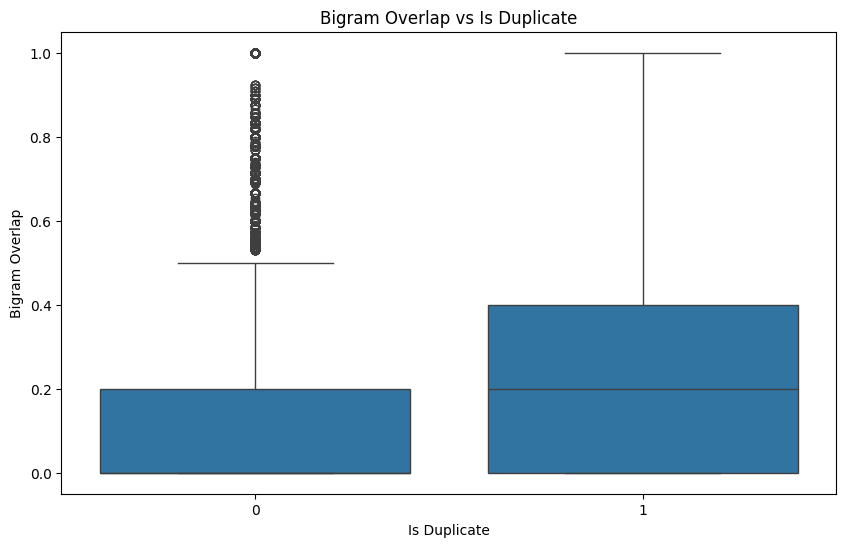

In [ ]:
# Visualization: Lengths, Overlaps, and Similarity
plt.figure(figsize=(10, 6))
plt.hist(df['q1_len'], bins=50, alpha=0.5, label='Question 1 Length')
plt.hist(df['q2_len'], bins=50, alpha=0.5, label='Question 2 Length')
plt.title('Distribution of Question Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=df['is_duplicate'], y=df['len_diff'])
plt.title('Length Difference vs Is Duplicate')
plt.xlabel('Is Duplicate')
plt.ylabel('Length Difference')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=df['is_duplicate'], y=df['word_overlap'])
plt.title('Word Overlap vs Is Duplicate')
plt.xlabel('Is Duplicate')
plt.ylabel('Word Overlap')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=df['is_duplicate'], y=df['named_entity_overlap'])
plt.title('Named Entity Overlap vs Is Duplicate')
plt.xlabel('Is Duplicate')
plt.ylabel('Named Entity Overlap')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=df['is_duplicate'], y=df['bigram_overlap'])
plt.title('Bigram Overlap vs Is Duplicate')
plt.xlabel('Is Duplicate')
plt.ylabel('Bigram Overlap')
plt.show()

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


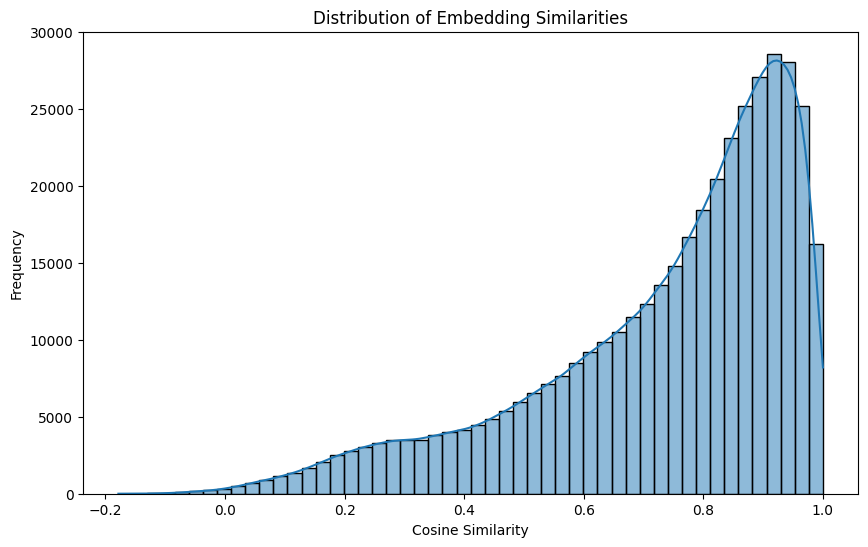

In [ ]:
# Transformer-based embeddings
from transformers import AutoTokenizer, AutoModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

def batch_embeddings(texts, tokenizer, model, device, batch_size=128):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            embeddings.append(outputs.last_hidden_state.mean(dim=1).cpu().numpy())
    return np.vstack(embeddings)

q1_embeddings = batch_embeddings(df['question1'].tolist(), tokenizer, model, device)
q2_embeddings = batch_embeddings(df['question2'].tolist(), tokenizer, model, device)

from sklearn.metrics.pairwise import cosine_similarity
df['embedding_similarity'] = [cosine_similarity([q1], [q2])[0][0] for q1, q2 in zip(q1_embeddings, q2_embeddings)]

plt.figure(figsize=(10, 6))
sns.histplot(df['embedding_similarity'], kde=True, bins=50)
plt.title('Distribution of Embedding Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Prepare Features and Target
features = [
    'embedding_similarity', 'len_diff', 'word_overlap', 'common_word_ratio',
    'named_entity_overlap', 'bigram_overlap', 'trigram_overlap'
]
X = df[features]
y = df['is_duplicate']

scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=features)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Train and evaluate traditional ML models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"{name} Accuracy: {accuracy_score(y_test, preds)}")
    print(f"{name} Classification Report:\n{classification_report(y_test, preds)}")

Random Forest Accuracy: 0.7968784783200178
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84     51026
           1       0.72      0.74      0.73     29832

    accuracy                           0.80     80858
   macro avg       0.78      0.79      0.78     80858
weighted avg       0.80      0.80      0.80     80858

Gradient Boosting Accuracy: 0.8093200425437186
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85     51026
           1       0.73      0.78      0.75     29832

    accuracy                           0.81     80858
   macro avg       0.79      0.80      0.80     80858
weighted avg       0.81      0.81      0.81     80858

XGBoost Accuracy: 0.8130302505627148
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85     51026
 

In [ ]:
# Ensemble using Logistic Regression
from sklearn.linear_model import LogisticRegression
train_probs = np.column_stack([model.predict_proba(X_train)[:, 1] for model in models.values()])
test_probs = np.column_stack([model.predict_proba(X_test)[:, 1] for model in models.values()])

meta_model = LogisticRegression().fit(train_probs, y_train)
ensemble_preds = meta_model.predict(test_probs)

print("Ensemble Accuracy:", accuracy_score(y_test, ensemble_preds))
print("Ensemble Classification Report:\n", classification_report(y_test, ensemble_preds))

Ensemble Accuracy: 0.790682430928294
Ensemble Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.82      0.83     51026
           1       0.71      0.74      0.72     29832

    accuracy                           0.79     80858
   macro avg       0.78      0.78      0.78     80858
weighted avg       0.79      0.79      0.79     80858



In [ ]:
import tensorflow.keras.backend as K
import gc
from tensorflow.compat.v1 import reset_default_graph

# Clear Keras session
K.clear_session()

# Reset TensorFlow default graph (for graph mode)
reset_default_graph()

# Trigger garbage collection
gc.collect()

print("GPU memory cleared!")

In [ ]:
# LSTM Siamese Model
from tensorflow.keras.layers import Input, LSTM, Dense, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
q1_embeddings = q1_embeddings.astype('float32')
q2_embeddings = q2_embeddings.astype('float32')

embedding_dim = q1_embeddings.shape[1]

# Shared model
def create_shared_model(input_dim):
    input_layer = Input(shape=(input_dim,))
    dense_layer = Dense(128, activation='relu')(input_layer)
    dropout_layer = Dropout(0.2)(dense_layer)
    dense_output = Dense(64, activation='relu')(dropout_layer)
    return Model(input_layer, dense_output)

# Siamese model
input_q1 = Input(shape=(embedding_dim,))
input_q2 = Input(shape=(embedding_dim,))
shared_model = create_shared_model(embedding_dim)

processed_q1 = shared_model(input_q1)
processed_q2 = shared_model(input_q2)

distance = Lambda(lambda tensors: tf.math.abs(tensors[0] - tensors[1]))([processed_q1, processed_q2])
output_layer = Dense(1, activation='sigmoid')(distance)

siamese_model = Model(inputs=[input_q1, input_q2], outputs=output_layer)
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the Siamese model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

siamese_model.fit(
    [q1_embeddings, q2_embeddings], y,
    batch_size=8, epochs=20,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)

I0000 00:00:1733208667.380269 2364637 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733208667.382880 2364637 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733208667.385342 2364637 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733208667.387847 2364637 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/20


I0000 00:00:1733208669.828160 2426994 service.cc:146] XLA service 0x74a314005cc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733208669.828205 2426994 service.cc:154]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
2024-12-03 06:51:09.859375: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-03 06:51:10.023934: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902


  154/40429 ━━━━━━━━━━━━━━━━━━━━ 39s 988us/step - accuracy: 0.5732 - loss: 0.6668

I0000 00:00:1733208671.550705 2426994 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40429/40429 ━━━━━━━━━━━━━━━━━━━━ 52s 1ms/step - accuracy: 0.7489 - loss: 0.4907 - val_accuracy: 0.8155 - val_loss: 0.3936 - learning_rate: 0.0010
Epoch 2/20
40429/40429 ━━━━━━━━━━━━━━━━━━━━ 46s 1ms/step - accuracy: 0.8062 - loss: 0.4066 - val_accuracy: 0.8072 - val_loss: 0.4067 - learning_rate: 0.0010
Epoch 3/20
40429/40429 ━━━━━━━━━━━━━━━━━━━━ 47s 1ms/step - accuracy: 0.8178 - loss: 0.3880 - val_accuracy: 0.8227 - val_loss: 0.3814 - learning_rate: 0.0010
Epoch 4/20
40429/40429 ━━━━━━━━━━━━━━━━━━━━ 47s 1ms/step - accuracy: 0.8233 - loss: 0.3772 - val_accuracy: 0.8159 - val_loss: 0.3950 - learning_rate: 0.0010
Epoch 5/20
40429/40429 ━━━━━━━━━━━━━━━━━━━━ 47s 1ms/step - accuracy: 0.8277 - loss: 0.3687 - val_accuracy: 0.8171 - val_loss: 0.3933 - learning_rate: 0.0010
Epoch 6/20
40429/40429 ━━━━━━━━━━━━━━━━━━━━ 47s 1ms/step - accuracy: 0.8381 - loss: 0.3520 - val_accuracy: 0.8168 - val_loss: 0.3943 - learning_rate: 5.0000e-04


In [ ]:
# Evaluate the Siamese model
y_pred_siamese = (siamese_model.predict([q1_embeddings[len(y_train):], q2_embeddings[len(y_train):]]) >= 0.5).astype(int)
print("Siamese Model Accuracy:", accuracy_score(y_test, y_pred_siamese))
print("Siamese Model Classification Report:\n", classification_report(y_test, y_pred_siamese))

2527/2527 ━━━━━━━━━━━━━━━━━━━━ 3s 904us/step
Siamese Model Accuracy: 0.512256053822751
Siamese Model Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.55      0.59     51026
           1       0.37      0.45      0.41     29832

    accuracy                           0.51     80858
   macro avg       0.50      0.50      0.50     80858
weighted avg       0.53      0.51      0.52     80858



In [ ]:
# LSTM Siamese

from tensorflow.keras.layers import Input, LSTM, Dense, Lambda, Dropout, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Ensure embeddings are float32
q1_embeddings = q1_embeddings.astype('float32')
q2_embeddings = q2_embeddings.astype('float32')

# Reshape embeddings for LSTM (if they are 2D, make them 3D for sequential processing)
q1_embeddings = q1_embeddings[:, None, :]  # Shape: (num_samples, 1, embedding_dim)
q2_embeddings = q2_embeddings[:, None, :]  # Shape: (num_samples, 1, embedding_dim)

embedding_dim = q1_embeddings.shape[2]

# Shared LSTM model
def create_shared_lstm_model(input_dim):
    input_layer = Input(shape=(None, input_dim))  # Accept variable-length sequences
    lstm_layer = Bidirectional(LSTM(128, return_sequences=False))(input_layer)
    dropout_layer = Dropout(0.2)(lstm_layer)
    dense_output = Dense(64, activation='relu')(dropout_layer)
    return Model(input_layer, dense_output)

# Siamese model
input_q1 = Input(shape=(None, embedding_dim))
input_q2 = Input(shape=(None, embedding_dim))
shared_lstm_model = create_shared_lstm_model(embedding_dim)

processed_q1 = shared_lstm_model(input_q1)
processed_q2 = shared_lstm_model(input_q2)

# Compute absolute difference between processed outputs
distance = Lambda(lambda tensors: tf.math.abs(tensors[0] - tensors[1]))([processed_q1, processed_q2])
output_layer = Dense(1, activation='sigmoid')(distance)

siamese_lstm_model = Model(inputs=[input_q1, input_q2], outputs=output_layer)
siamese_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the LSTM-based Siamese model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

siamese_lstm_model.fit(
    [q1_embeddings, q2_embeddings], y,
    batch_size=8,
    epochs=20,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/20
40429/40429 ━━━━━━━━━━━━━━━━━━━━ 260s 6ms/step - accuracy: 0.7709 - loss: 0.4566 - val_accuracy: 0.8250 - val_loss: 0.3749 - learning_rate: 0.0010
Epoch 2/20
40429/40429 ━━━━━━━━━━━━━━━━━━━━ 250s 6ms/step - accuracy: 0.8319 - loss: 0.3634 - val_accuracy: 0.8245 - val_loss: 0.3812 - learning_rate: 0.0010
Epoch 3/20
40429/40429 ━━━━━━━━━━━━━━━━━━━━ 251s 6ms/step - accuracy: 0.8436 - loss: 0.3403 - val_accuracy: 0.8281 - val_loss: 0.3782 - learning_rate: 0.0010
Epoch 4/20
40429/40429 ━━━━━━━━━━━━━━━━━━━━ 252s 6ms/step - accuracy: 0.8587 - loss: 0.3126 - val_accuracy: 0.8410 - val_loss: 0.3566 - learning_rate: 5.0000e-04
Epoch 5/20
40429/40429 ━━━━━━━━━━━━━━━━━━━━ 254s 6ms/step - accuracy: 0.8727 - loss: 0.2866 - val_accuracy: 0.8454 - val_loss: 0.3536 - learning_rate: 5.0000e-04
Epoch 6/20
40429/40429 ━━━━━━━━━━━━━━━━━━━━ 254s 6ms/step - accuracy: 0.8813 - loss: 0.2704 - val_accuracy: 0.8513 - val_loss: 0.3434 - learning_rate: 5.0000e-04
Epoch 7/20
40429/40429 ━━━━━━━━━━━━━━━━━